# Assignment (other assignment is [here](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/regression_assumptions_house.ipynb))
### 1.1 Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

```
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
```

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [3]:
df.shape

(96453, 12)

That is a pretty mad amount of data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 7.7+ MB


In [5]:
data = df[['temperature', 'humidity', 'windspeed', 'windbearing', 'pressure']].copy()

In [6]:
data.describe()

,temperature,humidity,windspeed,windbearing,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,11.932678,0.734899,10.810640,187.509232,1003.235956
std,9.551546,0.195473,6.913571,107.383428,116.969906
min,-21.822222,0.000000,0.000000,0.000000,0.000000
25%,4.688889,0.600000,5.828200,116.000000,1011.900000
50%,12.000000,0.780000,9.965900,180.000000,1016.450000
75%,18.838889,0.890000,14.135800,290.000000,1021.090000
max,39.905556,1.000000,63.852600,359.000000,1046.380000


No nulls, what do the distributions look like? Do we have outliers?

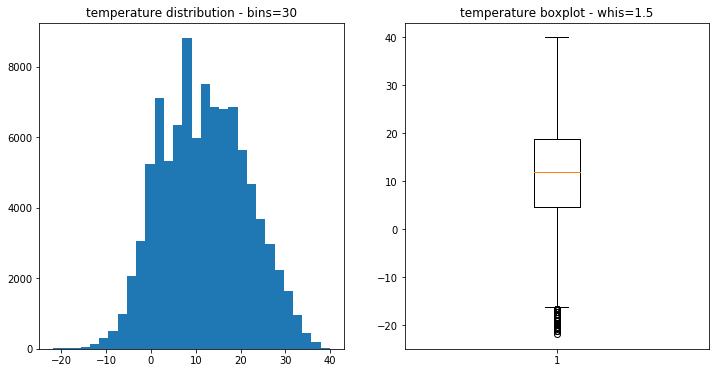

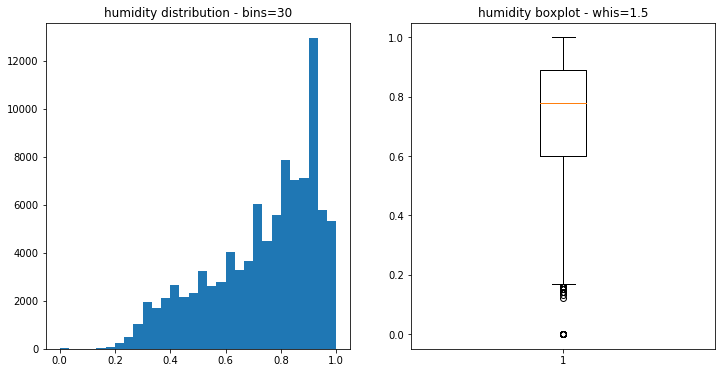

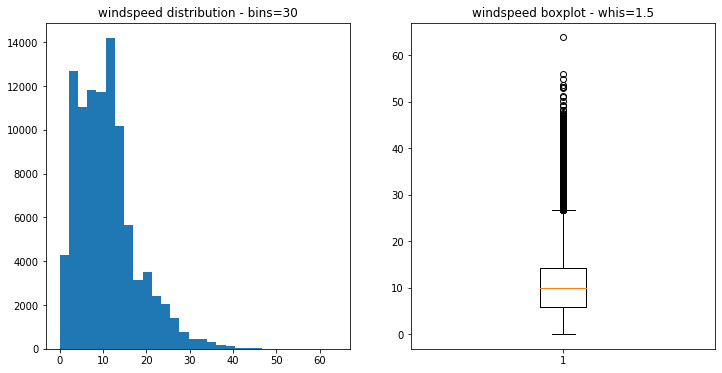

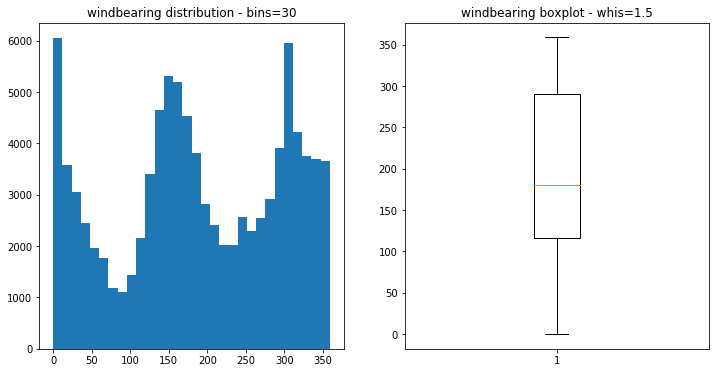

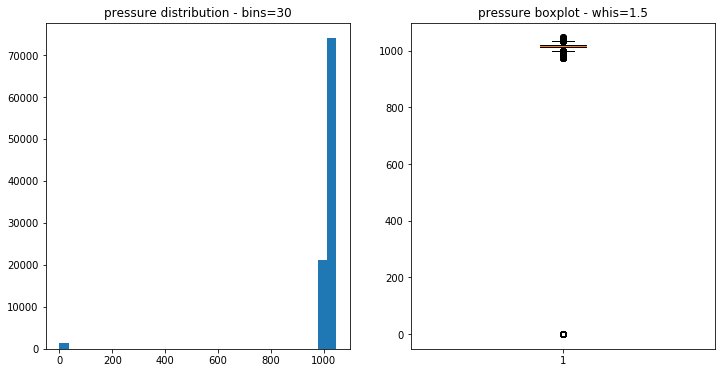

In [7]:
def hist_box(data, columns):
    for col in columns:
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.hist(data[col], bins=30)
        plt.title('{} distribution - bins=30'.format(col))
        plt.subplot(122)
        plt.boxplot(data[col])
        plt.title('{} boxplot - whis=1.5'.format(col))
        plt.show()
hist_box(data, data.columns)

Since this is weather data, I'm sure problems occur with the measuring equipment all the time - in the case of pressure, it seems like that bottom outlier is flat out not possible, so there are definitely errors here. Values two standard deviations from the mean or greater will be filtered out.

In [8]:
def outliers_std(data, columns, thresh=2):
    outlier_indexes = []
    for col in columns:
        ser_col = data[col]
        mean = ser_col.mean()
        sd = ser_col.std()
        outliers_mask = data[(data[col] > mean + thresh*sd) | (data[col] < mean - thresh*sd)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [9]:
def outliers_iqr(data, columns, thresh=1.5):
    outlier_indexes = []
    for col in columns:
        q25, q75 = np.percentile(data[col], [25, 75])
        iqr = q75 - q25
        upper_lim = q75 + (iqr*thresh)
        lower_lim = q25 - (iqr*thresh)
        outliers_mask = data[(data[col] >= upper_lim) | (data[col] <= lower_lim)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [10]:
len(outliers_std(data, data.columns)), len(outliers_iqr(data, data.columns))

(11816, 7184)

In [11]:
data.drop(outliers_iqr(data, data.columns), inplace=True)

Looks like we lose less data if we use Tukey's method - lets go with that.

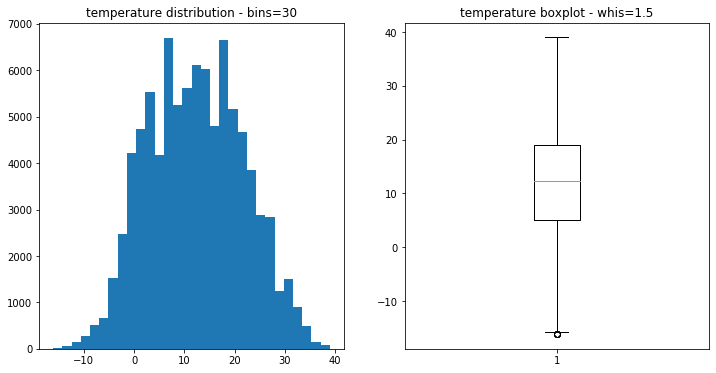

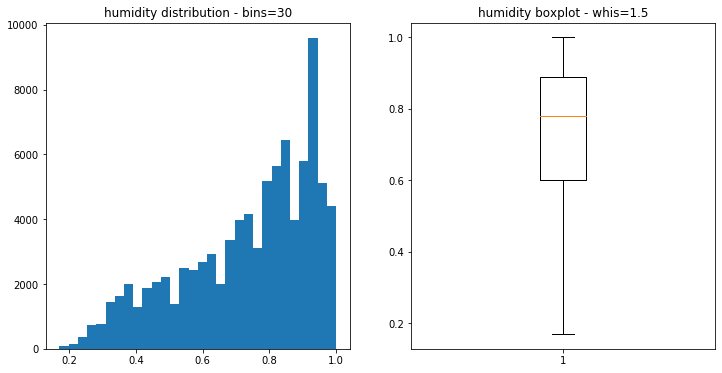

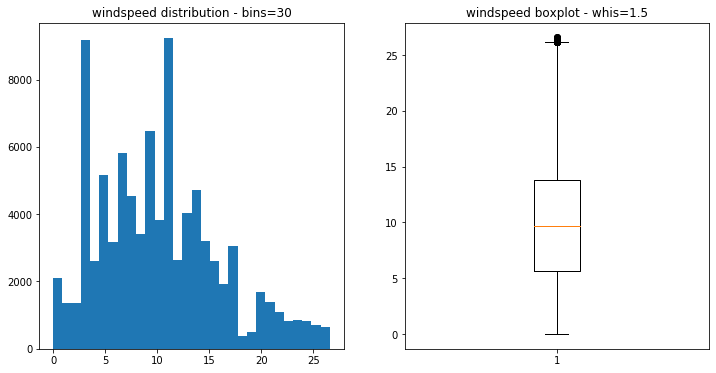

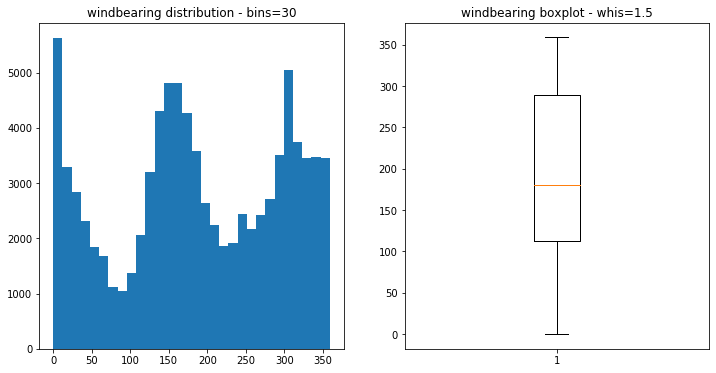

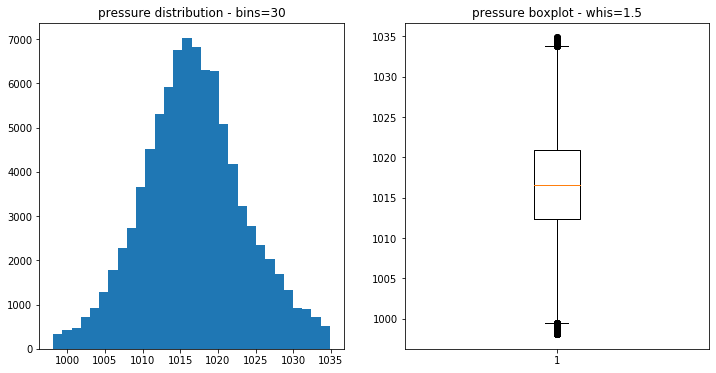

In [12]:
hist_box(data, data.columns)

Much better. On to modeling - since they want us to get straight to it (exploration mostly skipped).

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [14]:
data_X = scaled_data.iloc[:, 1:]
target = scaled_data.iloc[:, 0]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, target, test_size=.3, random_state=21)

In [16]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)

In [17]:
from sklearn import metrics
def evaluate(Y_test, Y_pred):
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    msa = metrics.mean_absolute_error(Y_test, Y_pred)
    r2 = metrics.r2_score(Y_test, Y_pred)
    
    print('Mean squared error:', mse)
    print('Mean absolute error:', msa)
    print('R^2:', r2)
    
    plt.scatter(Y_test, Y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

Mean squared error: 0.4655544638300769
Mean absolute error: 0.5514044149674787
R^2: 0.5334108111818375


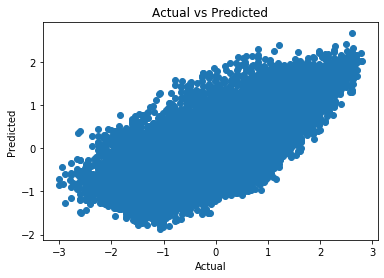

In [18]:
evaluate(Y_test, Y_pred)

Not bad, not great...let's dig into these assumptions.

### The Assumptions
1. Linearity of models in their coefficients
2. Error term should be zero on average
3. Homoscedasticity
4. Low Multicollinearity
5. Error terms should be uncorrelated with each other
6. Features shouldn’t be correlated with the errors

    (sorta 7.) Normality of the errors

#### 1. Linearity of models in their coefficients
The only requirement of this model is that our coefficients end up being a linear relationship of our features. Using a linear model, assumes this already in code we can see that our coefficients remain constant (linear) regardless of changes to other variables.

In [19]:
lm.coef_

array([-0.68003414, -0.19504048,  0.02391226, -0.31918396])

#### 2. Error term should be zero on average

This pretty much means exactly what it says and we can test this assumption rather easily.

In [20]:
errors = Y_test - Y_pred
np.mean(errors)

-0.002563016008161624

This isn't quite zero, but it is incredibly close, if we don't include a constant in our model, then this could become an issue, but Sci-Kit Learn does the heavy lifting and already assumes that there is a constant (y-intercept). This assumption is usually a non-issue, just don't forget about the constant.

#### 3. Homoscedasticity

We have homoscedasticity when the distribution of the error terms is consistent for all predicted values. Let's do a visual test...

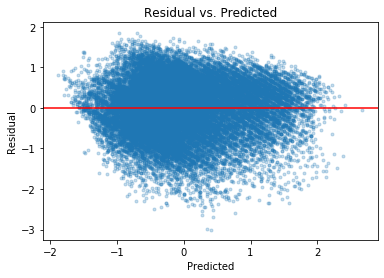

In [21]:
plt.scatter(Y_pred, errors, alpha=.25, marker='.')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, color='red')
plt.title('Residual vs. Predicted')
plt.show()

This distribution doesn't look too bad, looks like up higher there is more variance, but it isn't conclusive. Let's dig into some statistical testing! Time to look for some help from our friends Bartlett and Levene...

In [22]:
from scipy.stats import bartlett, levene

bartlett(Y_pred, errors), levene(Y_pred, errors)

(BartlettResult(statistic=125.59402855139601, pvalue=3.772829109641322e-29),
 LeveneResult(statistic=92.81883702129171, pvalue=5.970723300142703e-22))

The tests are highly significant! This means that our errors are heteroscedastic rather than homoscedastic. This is less than optimal and leads to overconfidence in the accuracy of the model's predictions. There are a number of possible causes. The main ones are the presence of outliers (which I think we took care of) and leaving out variables that are important in explaining the variance of the target variable. Note, the estimated coefficients are still valid, but not necessarily statistically significant.

Things that could possibly be done here:
- Add variable that describes dependent variables variance more robustly
- Transform the dependent variable using boxcox or log transformation
- Eliminate outliers (should be done already)

#### 4. Low Multicollinearity

The features themselves optimally would be completely uncorrelated, and at most weakly correlated. If two variables (or more) are highly correlated with one another, then they may explain mostly the same variance for a dependent variable. This takes away our ability to know the relative power of each variable since each variable could be a linear combination of others. Let's get a visual...

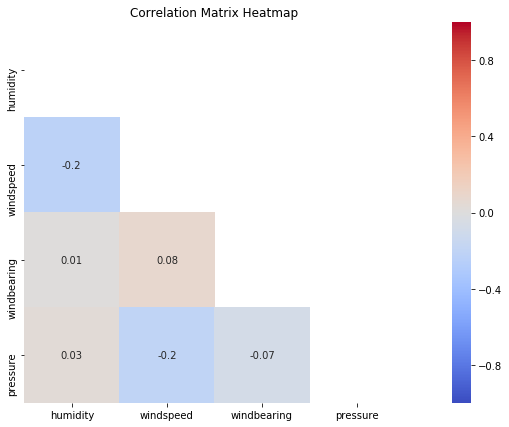

In [23]:
mask = np.triu(scaled_data.iloc[:, 1:].corr())
plt.figure(figsize=(17,7))
sns.heatmap(scaled_data.iloc[:, 1:].corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask, square=True)
plt.ylim(scaled_data.iloc[:, 1:].corr().shape[1], 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

The strongest correlation between features appears to be windspeed and humidity, and at -0.2, the correlation pretty weak. These features are not very multicollinear.

In the case that the variables were more highly correlated to one another there are a few courses of action:
- PCA (dimensionality reduction)
- Remove some of the correlated features

#### 5. Error terms should be uncorrelated with each other

The error terms should not be able to predict the error terms for other values. Quick visual...

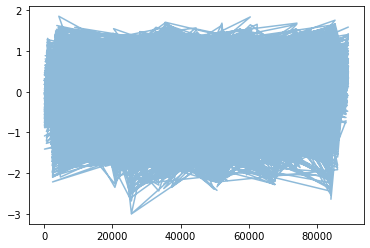

In [24]:
plt.plot(errors, alpha=.5)
plt.show()

Looks like a jumbled mess, which is good, because it implies there is no correlation. There is a more direct and explicit way to deal with this using the autocorrelation function or ACF.

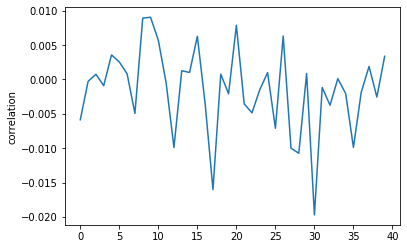

In [25]:
from statsmodels.tsa.stattools import acf
plt.plot(acf(errors, fft=False)[1:])
plt.ylabel('correlation')
plt.show()

The correlation between error values at its highest is less than .01 and at its lowest -0.02. This shows there is practically no correlation between our error values.

If we were to find a correlation between error values the likely culprit would be missing a relevant variable and the best way to take care of that issue is to add the relevant variable to our model.

#### 6. Features shouldn’t be correlated with the errors

Also known as the exogeneity assumption, this assumes features and errors are independent of one another. This will usually occur if you either omit a relevant variable from the model or if there is simultaneity in the effect between an independent and dependent variable.

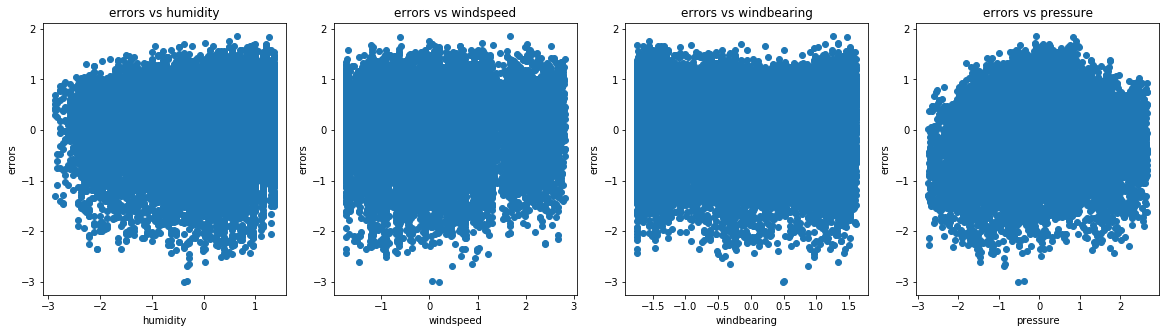

In [26]:
plt.figure(figsize=(20, 5))
for i, col in enumerate(X_test.columns, 1):
    plt.subplot(1, 4, i)
    plt.scatter(X_test[col], errors)
    plt.xlabel(col)
    plt.ylabel('errors')
    plt.title('errors vs {}'.format(col))
plt.show()

It would appear, based on the above, we don't have a relationship between errors or their plots would likely indicate more than a blob. This is good. It means we don't have exogeneity.

#### 7(ish). Normality of the errors

Not an assumption, but does carry weight when it comes to the results. We don't need it to come up with coefficients. But we do need it if we want to measure the statistical significance of our coefficients (t-tests and F-tests, yay!). If the errors aren't normal, then the significance tests are useless. Visually...

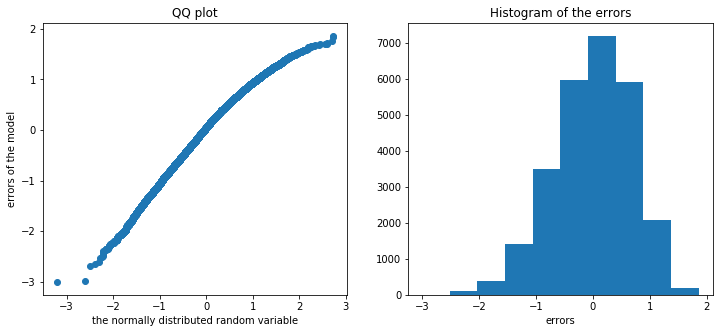

In [27]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")
plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")
plt.show()

So, based on the above, the errors may not be perfectly normal, but they do appear to be quite close.

A more direct and formal statistical method could be performed as well thanks to our friends Jarque Bera and Normal test.

In [28]:
from scipy.stats import jarque_bera, normaltest
jarque_bera(errors), normaltest(errors)

((745.5472526520023, 0.0),
 NormaltestResult(statistic=691.3496019709886, pvalue=7.504839331086358e-151))

These highly significant results indicate that our data deviates more drastically from the norm than it may have appeared...this will likely make it difficult to garner any significance from our coefficients...bummer.